In [1]:
folder = "/media/kakn/storage/prometheus_export/low_v2"

In [2]:
import json, os

values = {}

files = [
    "processor_cpu_full.json",
    "processor_memory_full.json",
    "kafka-0_cpu_full.json",
    "kafka-0_memory_full.json",
    "kafka-1_cpu_full.json",
    "kafka-1_memory_full.json",
    "kafka-2_cpu_full.json",
    "kafka-2_memory_full.json"
    ]

for file in files:
    with open(os.path.join(folder, file), "r") as f:
        values[file] = json.load(f)["data"]["result"][0]["values"]
        values[file] = list(map(lambda x: (x[0], float(x[1])), values[file]))

In [3]:
range_start = 0
range_stop = 0

for i in range(len(values["processor_cpu_full.json"]) - 19 ):
    if all(values["processor_cpu_full.json"][j][1] < 0.5 for j in range(i, i + 20)):
        range_start = values["processor_cpu_full.json"][i][0]
        break

for i in range(len(values["processor_cpu_full.json"]) - 9):
    if all(values["processor_cpu_full.json"][j][1] < 0.02 for j in range(i, i + 10)):
        range_stop = values["processor_cpu_full.json"][i-1][0]
        break

for series in values:
    values[series] = list(filter(lambda x: x[0] >= range_start and x[0] <= range_stop, values[series]))

In [4]:
import numpy as np
import scipy.stats as sp

statistic = {}

for series in values:
    values[series] = np.array(values[series])
    statistic[series] = {
        "mean": np.mean(values[series][:,1]),
        "median": np.median(values[series][:,1]),
        "std": np.std(values[series][:,1]),
        "min": np.min(values[series][:,1]),
        "max": np.max(values[series][:,1]),
        "percentile_95": np.percentile(values[series][:,1], 95),
        "percentile_99": np.percentile(values[series][:,1], 99)
    }

print(json.dumps(statistic, indent=4))

{
    "processor_cpu_full.json": {
        "mean": 0.042450197595728795,
        "median": 0.04162876506017891,
        "std": 0.008243500209584984,
        "min": 0.013754935330099699,
        "max": 0.2912713387241178,
        "percentile_95": 0.04911974215450857,
        "percentile_99": 0.05431000885722417
    },
    "processor_memory_full.json": {
        "mean": 1846187862.1551633,
        "median": 1878138880.0,
        "std": 40300469.00969317,
        "min": 1696227328.0,
        "max": 1878888448.0,
        "percentile_95": 1878609920.0,
        "percentile_99": 1878637076.48
    },
    "kafka-0_cpu_full.json": {
        "mean": 0.057740424522921316,
        "median": 0.055761018001243806,
        "std": 0.011912785416349372,
        "min": 0.025921135646693745,
        "max": 0.25122182468694376,
        "percentile_95": 0.06444590785302597,
        "percentile_99": 0.11713411668307463
    },
    "kafka-0_memory_full.json": {
        "mean": 1106267832.363831,
        "media

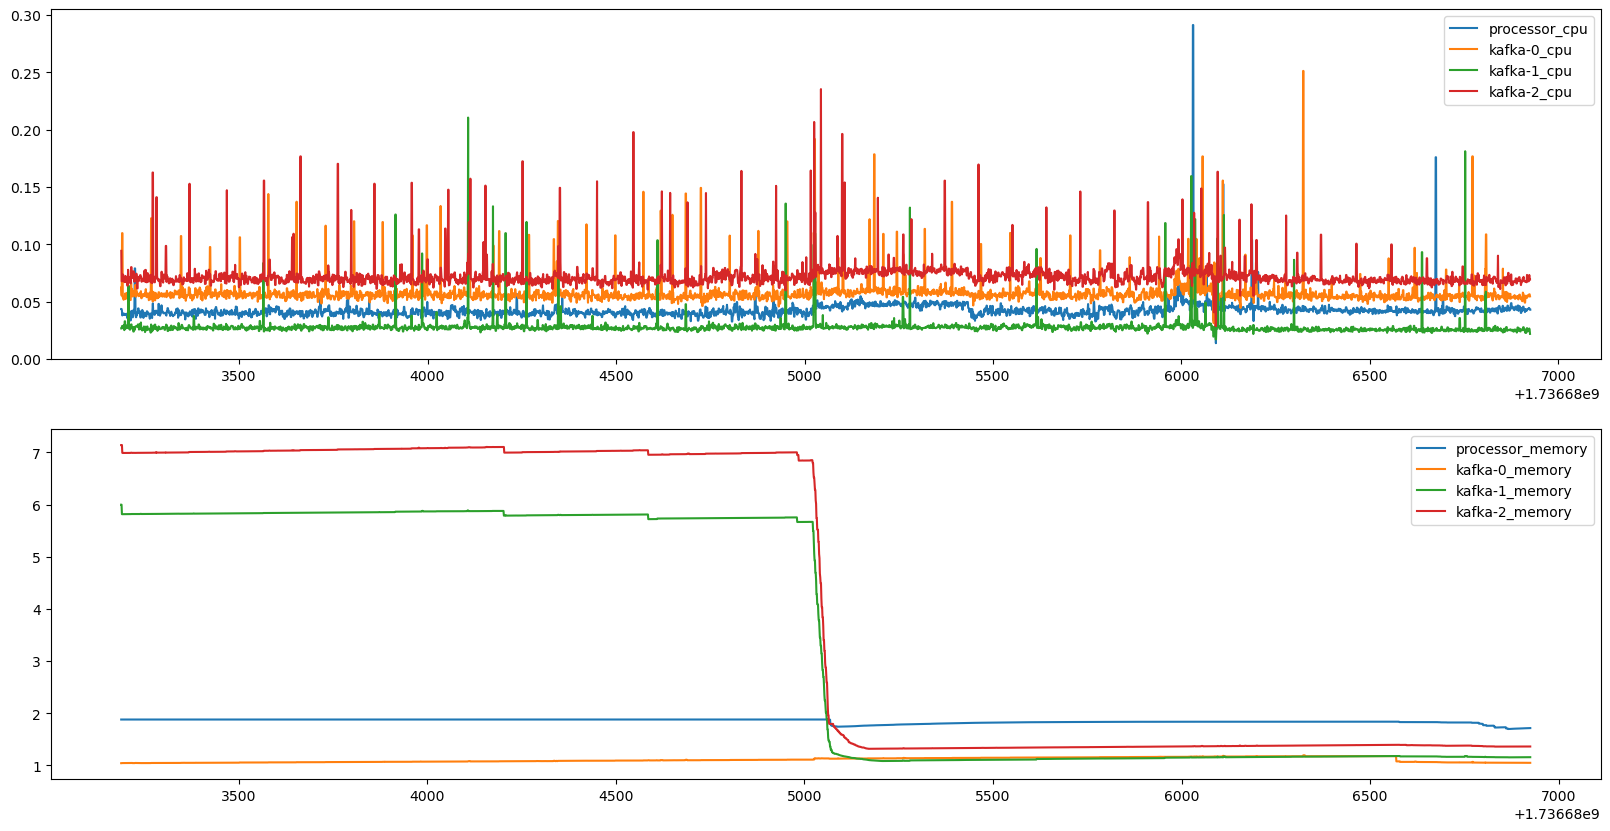

In [12]:
#plot ressource usage of processor and kafka

import matplotlib.pyplot as plt

#umrechnung von byte in gb

GBValues = {}

for series in values:
    if "memory" in series:
        GBValues[series] = np.array(list(map(lambda x: (x[0], x[1] / 1000 / 1000 / 1000), values[series])))

plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
plt.plot(values["processor_cpu_full.json"][:,0], values["processor_cpu_full.json"][:,1], label="processor_cpu")
plt.plot(values["kafka-0_cpu_full.json"][:,0], values["kafka-0_cpu_full.json"][:,1], label="kafka-0_cpu")
plt.plot(values["kafka-1_cpu_full.json"][:,0], values["kafka-1_cpu_full.json"][:,1], label="kafka-1_cpu")
plt.plot(values["kafka-2_cpu_full.json"][:,0], values["kafka-2_cpu_full.json"][:,1], label="kafka-2_cpu")
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(GBValues["processor_memory_full.json"][:,0], GBValues["processor_memory_full.json"][:,1], label="processor_memory")
plt.plot(GBValues["kafka-0_memory_full.json"][:,0], GBValues["kafka-0_memory_full.json"][:,1], label="kafka-0_memory")
plt.plot(GBValues["kafka-1_memory_full.json"][:,0], GBValues["kafka-1_memory_full.json"][:,1], label="kafka-1_memory")
plt.plot(GBValues["kafka-2_memory_full.json"][:,0], GBValues["kafka-2_memory_full.json"][:,1], label="kafka-2_memory")
plt.legend()
plt.show()


In [6]:
print("time_range = [%d,%d]" % (int(range_start * 1000), int(range_stop * 1000)))

time_range = [1736683187262,1736686925262]
